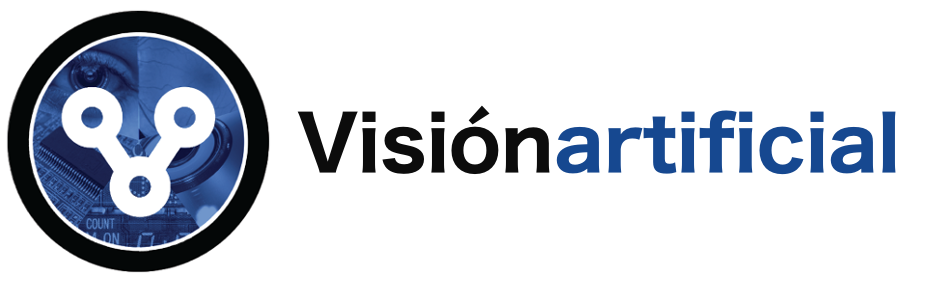

# OpenCV 

### para a materia de Visión Artificial do Grao de Robótica. EPSE de Lugo.

<hr style = "border: none; height: 4px; background-color: # D3D3D3" />

# 1. Homografías 2D - Aplicacións

Agora xa estás familiarizado coas homografías, este caderno propón dúas aplicacións máis en deportes onde o uso desta técnica mellora a experiencia do espectador. Pídese que implemente unha solución para cada un. Como xa sabedes os fundamentos do cómputo de homografía, este caderno non abordará ningún aspecto teórico, senón que só presenta as aplicacións para que as entendas e xogues con elas!

### Algunhas notas sobre a implementación
- Se usas o comando `%matplotlib notebook`, poderás obter as coordenadas da imaxe na posición do rato. Use isto **en cada cela** cando necesite seleccionar puntos nas imaxes. Desafortunadamente, isto non funciona en todos os frameworks Jupyter (non en Google Colab, por exemplo). Se non funciona, terás que obter as coordenadas do punto abrindo a imaxe cunha aplicación típica de procesamento de imaxes (como Irfanview, GIMP, etc.).
- Ten en conta que cando estás calculando unha homografía estás transformando as coordenadas da imaxe a coordenadas do *mundo real* (as do plano real e non deformado), polo que se estas últimas **son demasiado pequenas** acabarás cunha pequena imaxe sen deformar. Isto fará máis difícil conseguir referencias nunha imaxe tan pequena. Dalgunha maneira, estás *perdendo resolución*. Entón, ao crear as coordenadas dos planos non deformados, use un valor (factor) para multiplicar as coordenadas reais para obter unha imaxe o suficientemente grande como para recoller os puntos correctamente.

In [1]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

# Directorio de imaxes
images_path = './images/'

# Isto permitirache ver a posición do píxel onde apunta o rato
%matplotlib notebook
%matplotlib inline

## 1.2  Aplicación 1: Competición de salto de lonxitude

A *comité de Xogos Olímpicos* ten un traballo especial para ti: desenvolver un programa de visión por ordenador capaz de decidir se un salto é válido (o saltador non superou o taboleiro de plastilina) e a distancia desde o chanzo ata este taboleiro.

A seguinte imaxe mostra as partes da zona onde o saltador debe despegar: a **taboa de despegue** (cunha anchura de 20 cm), a **liña de despegue** (fóra de bordo) e o **indicador de plastilina** (10 cm de ancho). En total, a área desta zona é de **30$\times$122cm**.

<img src="./images/take_off_zone.png" width="300">$\\[5pt]$

O *comité dos Xogos Olímpicos* quere que avalúes o teu software usando unha serie de imaxes proporcionadas, denominadas `long_jump_0.png` ata `lon_jump_4.png`, que están anotadas coa distancia desde a punta da zapatilla de deporte do puente ata o inicio do indicador de plastilina. Con este obxectivo, implementa un código que:
- Calcule a homografía entre a zona de despegue nas imaxes e un rectángulo co tamaño real (30x122cm).
- Selecciona manualmente o punto na punta da zapatilla de deporte do saltador na zona sen perspectiva.
- Tendo esa coordenada, calcula e informa a distancia desde ela ao indicador de plastilina.

Esta distancia é a mesma que a proporcionada nas imaxes?

<IPython.core.display.Javascript object>


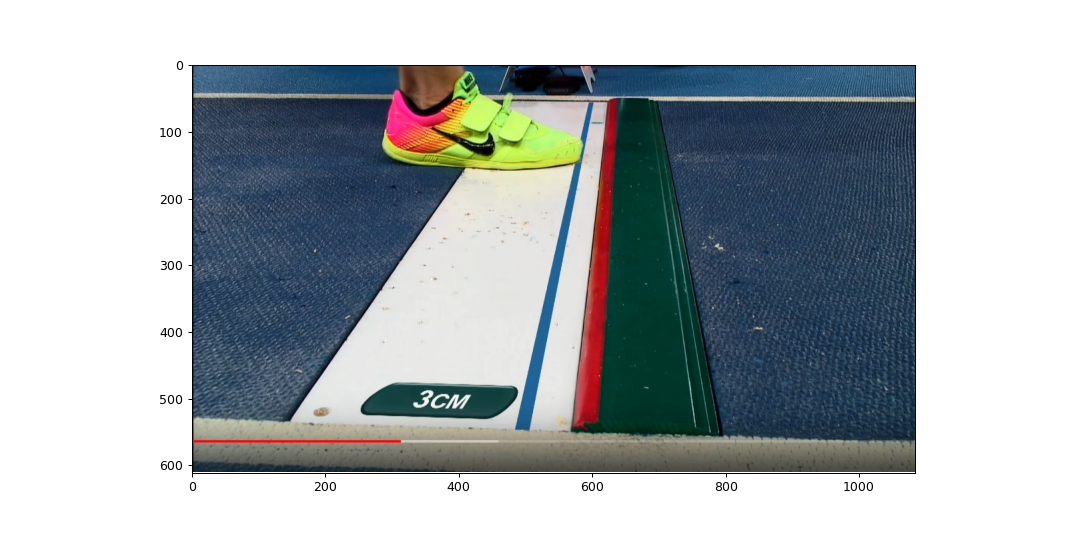

In [23]:
%matplotlib inline
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

# APPLICACION 1: competicion de salto
# Escribe aqui o teu codigo!

# cargamos a imaxe
image = cv2.imread(images_path + 'long_jump_0.png')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

# visualizamos
plt.imshow(image);

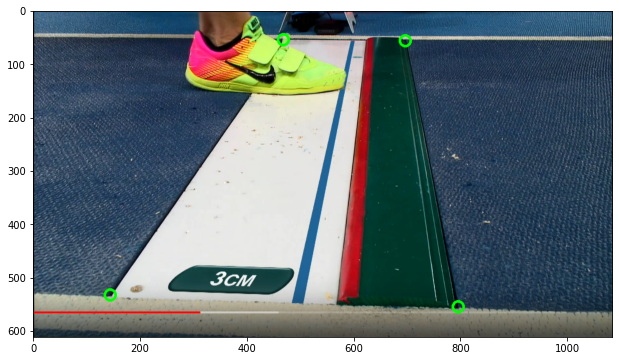

In [24]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

# Coordenadas dos puntos nas imaxes
pts_src = np.array([[468,  55],
                    [696,  57],
                    [144, 532],
                    [795, 554]])

image_draw = np.copy(image)
for i in range(4):
    cv2.circle(image_draw,(pts_src[i][0],pts_src[i][1]),10,(0,255,0),3)
plt.imshow(image_draw);

<IPython.core.display.Javascript object>


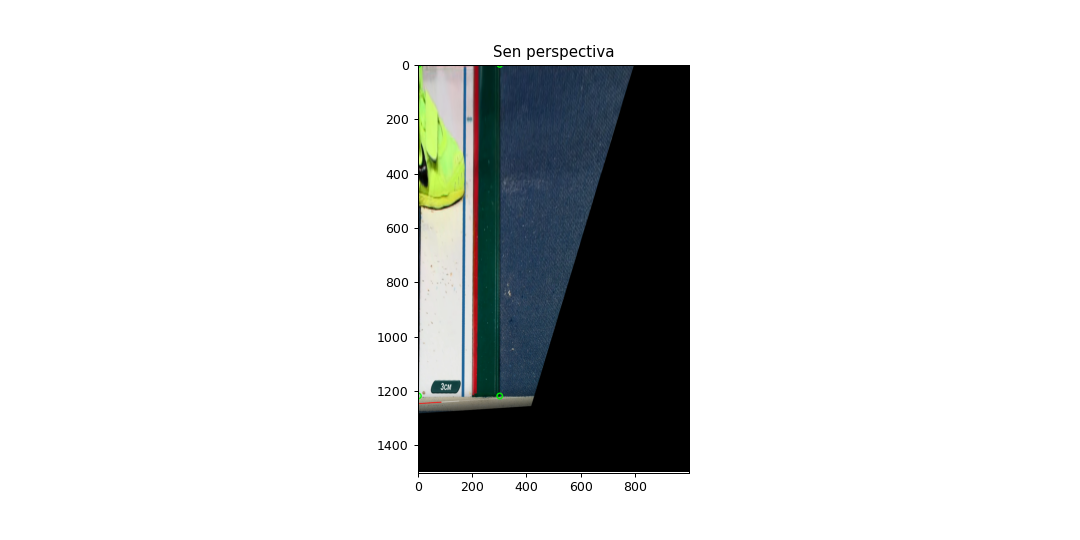

Distancia: 3.0 cm


In [47]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
%matplotlib notebook
#%matplotlib inline

# Puntos do rectangulo sen perpectiva
factor = 10 # para unha mellor resolucion
w = 30*factor
h = 122*factor
pts_dst = np.array([[1, 1], [w, 1], [1, h], [w, h]])



# Calculamos a homografia
M, status = cv2.findHomography(pts_src, pts_dst)

# Deformar a imaxe de orixe ata o destino en función da homografía
no_perspective = cv2.warpPerspective(image, M, (1000,1500))
for i in range(4):
    cv2.circle(no_perspective,(pts_dst[i][0],pts_dst[i][1]),10,(0,255,0),3)
plt.title('Sen perspectiva')
plt.imshow(no_perspective);




# Coordenadas punta zapatilla (achadas empregando o factor = 10!)
q = (np.array([170,475])/10)*factor

# Calcula a distancia: w-q[0] é a distancia en píxeles na imaxe deformada
distance = (w-q[0])/factor-10
print("Distancia: %.1f cm" % distance)

## 1.2 Aplicación 2: detección de fóra de xogo

*LaLiga* tamén chamou ás nosas oficinas pedindo un software para axudar ao VAR e trazar unha liña na posición do último defensor nun partido de fútbol, facilitando deste xeito decidir se un xogador estaba fóra de xogo.

<img src="./images/offside.jpg" width="600">$\\[5pt]$

Para cumprir este requisito, desenvolve un programa que utilice a imaxe `offside.jpg` e:
- Elimine a perspectiva da área de penalti. O tamaño desta área é de 16,5 x 40,3 m.
- Consigue (manualmente) dous puntos nas posicións do último defensor e do dianteiro.
- Debuxa unha liña na imaxe (orixinal) que cruzan esa posición.

Agora tes as ferramentas axeitadas, poderías dicir se o gol de Luis Suárez é legal? Podes determinar a distancia en metros entre as liñas para o defensor e o dianteiro?

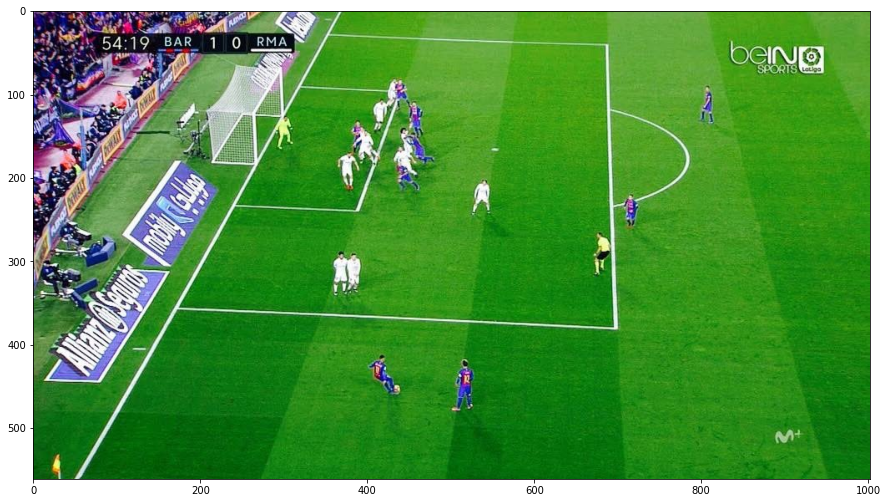

In [9]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

# APLICACION 2: deteccion de fora de xogo

# Cargamos a imaxe
image = cv2.imread(images_path + 'offside.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

# Visualiza
plt.imshow(image);

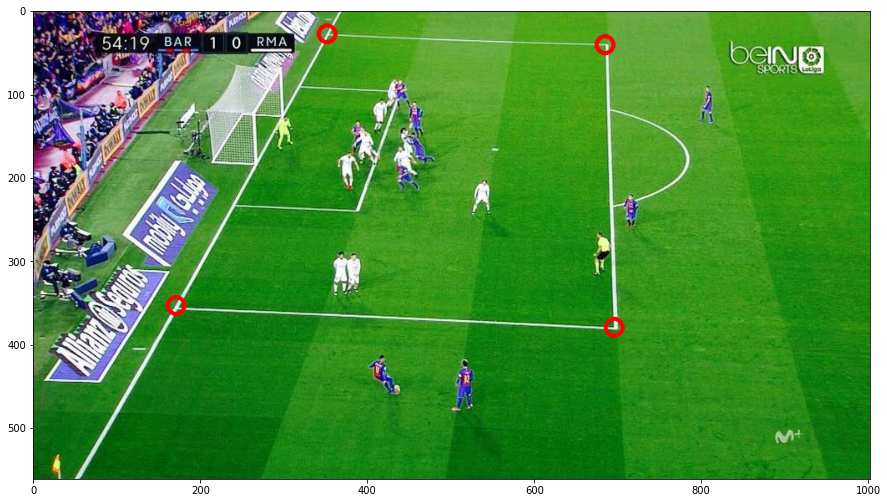

In [12]:
#%matplotlib notebook
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

# Coordendas dos puntos nas esquinas da área grande
pts_src = np.array([[352, 28],
                    [685, 41],
                    [171,353],
                    [696,379]])

image_draw = np.copy(image)
for i in range(4):
    cv2.circle(image_draw,(pts_src[i][0],pts_src[i][1]),10,(255,0,0),3)
plt.imshow(image_draw);

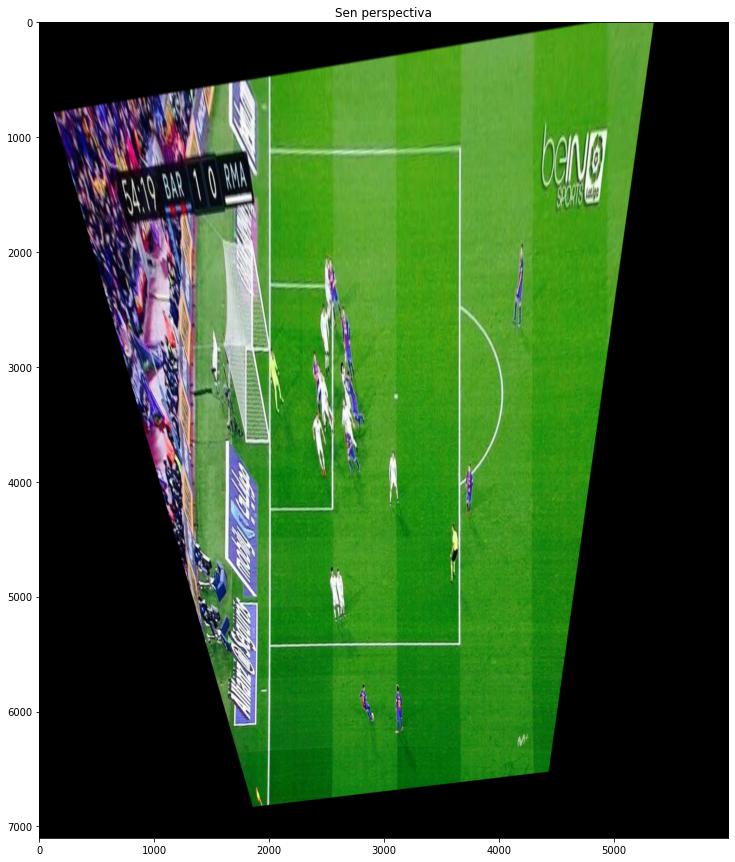

In [16]:
# %matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

# Puntos do rectangulo da area sen distorsion
factor = 100 # factor para que a imaxe transformada sexa mais grande (decidido polo usuario)
w = 16.5*factor
h = 43.0*factor
#colocamos o primeiro punto da area na psocion 20,11 *factor (para que quede mais ao centro e non corte ao publico!)
offset_w = 20*factor
offset_h = 11*factor

pts_dst = np.array([[  offset_w,   offset_h], 
                    [w+offset_w,   offset_h], 
                    [  offset_w, h+offset_h], 
                    [w+offset_w, h+offset_h]])

# Calculamos a homografia
M, status = cv2.findHomography(pts_src, pts_dst)

# Deformamos a imaxe de orixe en función da homografía
no_perspective = cv2.warpPerspective(image, M, (offset_w+4000,offset_h+6000))
plt.title('Sen perspectiva')
plt.imshow(no_perspective);

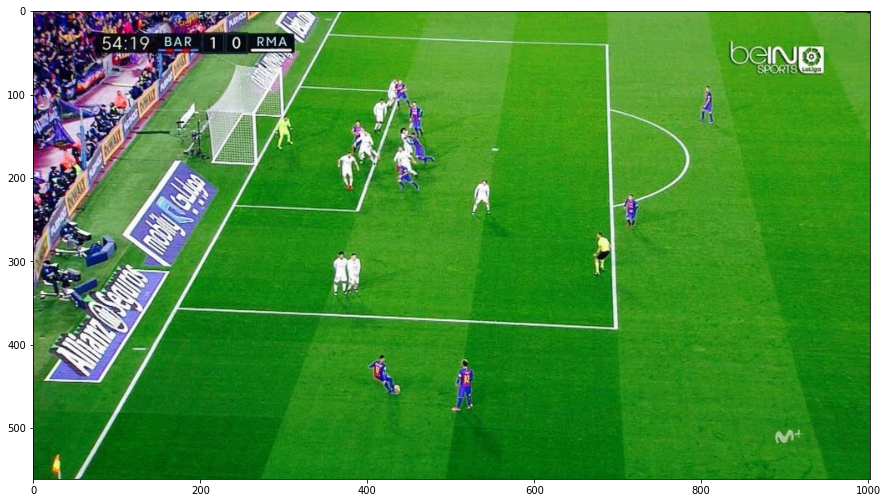

In [18]:
# %matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

# Puntos da linha de defensa e de ataque (seleccionados manualmente)
qd_x = offset_w+394
qa_x = offset_w+383
    
# Homografia inversa
invM = np.linalg.inv(M)

# Obtén de novo a perspectiva orixinal
perspective = cv2.warpPerspective(no_perspective, invM, (image.shape[1],image.shape[0]))
plt.imshow(perspective);

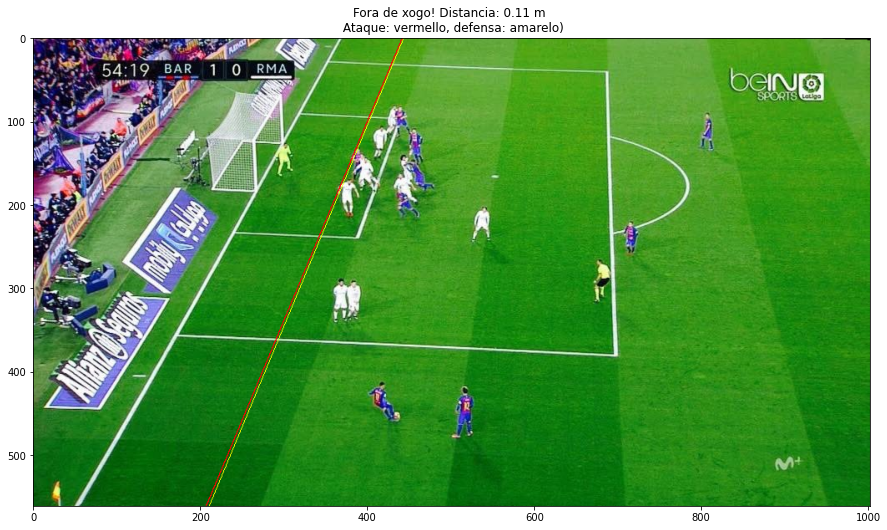

In [19]:
# %matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

# Liñas de interese
# Escolle dous puntos en coordendas homoxéneas contidos na liña de defensa
def_line = np.array([[qd_x, qd_x],
                     [   0, 4000],
                     [   1,    1]])

# PEscolle dous puntos en coordendas homoxéneas contidos na liña de ataque
ata_line = np.array([[qa_x, qa_x],
                     [   0, 4000],
                     [   1,    1]])

# Aplicar homografa inversa aos puntos da recta DEFENSA tomados na imaxe sen perspectiva
def_line_perspective = invM @ def_line
def_line_perspective = (def_line_perspective / def_line_perspective[2])[0:2] # homogeneous

x1,y1 = def_line_perspective[0,0], def_line_perspective[1,0]
x2,y2 = def_line_perspective[0,1], def_line_perspective[1,1]

# Calcula a pendente para estender o segmento de recta
def_slope = (y2-y1)/(x2-x1)

# Estende o segmento de liña
x1,y1 = int(x1+3000), int(y1+3000*def_slope)
x2,y2 = int(x2-3000), int(y2-3000*def_slope)

# Debuxa a liña de defensa
cv2.line(perspective, (x1,y1), (x2,y2),(255,255,0))

# Aplicar homografía inversa aos puntos da liña ATAQUE tomados na imaxe sen perspectiva
ata_line_perspective = invM @ ata_line
ata_line_perspective = (ata_line_perspective / ata_line_perspective[2])[0:2] # homogeneous

x1,y1 = ata_line_perspective[0,0], ata_line_perspective[1,0]
x2,y2 = ata_line_perspective[0,1], ata_line_perspective[1,1]

# Calcula a pendente para estender o segmento de recta
ata_slope = (y2-y1)/(x2-x1)

# Estende o segmento de liña
x1,y1 = int(x1+3000), int(y1+3000*ata_slope)
x2,y2 = int(x2-3000), int(y2-3000*ata_slope)

# Debuxa a liña de ataque
cv2.line(perspective, (x1,y1), (x2,y2),(255,0,0), 1, 4)

# Resultados do VAR
plt.imshow(perspective);
distance = (qd_x-qa_x)/factor
if distance > 0:
    plt.title("Fora de xogo! Distancia: %.2f m \n Ataque: vermello, defensa: amarelo" % distance)
else:
    plt.title("Posicion correcta! Distancia: %.2f m \n Ataque: vermello, defensa: amarelo" % distance)